In [ ]:
import sys
import os
# 将项目根目录下的 src 文件夹添加到 sys.path 中
sys.path.append(os.path.abspath(os.path.join('..', 'src')))


In [11]:
import matplotlib as mpl
import numpy as np
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
# 方法1：使用系统中已有的中文字体
fonts = [f.name for f in fm.fontManager.ttflist if '微软雅黑' in f.name or 'SimHei' in f.name or 'SimSun' in f.name or 'Microsoft YaHei' in f.name]
if fonts:
    plt.rcParams['font.family'] = fonts[0]
    print(f"使用字体: {fonts[0]}")
else:
    # 方法2：使用matplotlib内置的中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    print("使用默认中文字体配置")

使用字体: Microsoft YaHei


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.mnist_cnn_improved import MNIST_CNN_Improved  # 导入优化后的模型

# 定义数据增强和预处理
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载数据集
train_dataset = datasets.MNIST(os.path.join('..', 'data'), train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(os.path.join('..', 'data'), train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
model = MNIST_CNN_Improved().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, min_lr=1e-5)

num_epochs = 20
best_val_loss = float('inf')
patience = 5   # 提前停止条件：连续 5 个 epoch 验证 loss 无下降
trigger_times = 0

train_losses = []
val_losses = []
accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * data.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_val_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    accuracies.append(accuracy)
    
    print(f'Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}, Accuracy = {accuracy:.2f}%')
    
    scheduler.step(epoch_val_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), os.path.join('..', 'saved_models', 'mnist_cnn_improved.pt'))
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break


Epoch 1: Train Loss = 0.2625, Val Loss = 0.0396, Accuracy = 98.82%
Epoch 2: Train Loss = 0.1133, Val Loss = 0.0288, Accuracy = 98.97%
Epoch 3: Train Loss = 0.0909, Val Loss = 0.0260, Accuracy = 99.19%
Epoch 4: Train Loss = 0.0800, Val Loss = 0.0232, Accuracy = 99.27%
Epoch 5: Train Loss = 0.0709, Val Loss = 0.0203, Accuracy = 99.35%
Epoch 6: Train Loss = 0.0668, Val Loss = 0.0219, Accuracy = 99.18%
Epoch 7: Train Loss = 0.0635, Val Loss = 0.0179, Accuracy = 99.39%
Epoch 8: Train Loss = 0.0600, Val Loss = 0.0202, Accuracy = 99.39%
Epoch 9: Train Loss = 0.0575, Val Loss = 0.0192, Accuracy = 99.37%
Epoch 10: Train Loss = 0.0511, Val Loss = 0.0172, Accuracy = 99.45%
Epoch 11: Train Loss = 0.0501, Val Loss = 0.0146, Accuracy = 99.56%
Epoch 12: Train Loss = 0.0498, Val Loss = 0.0165, Accuracy = 99.47%
Epoch 13: Train Loss = 0.0488, Val Loss = 0.0142, Accuracy = 99.51%
Epoch 14: Train Loss = 0.0463, Val Loss = 0.0147, Accuracy = 99.58%
Epoch 15: Train Loss = 0.0462, Val Loss = 0.0168, Accurac

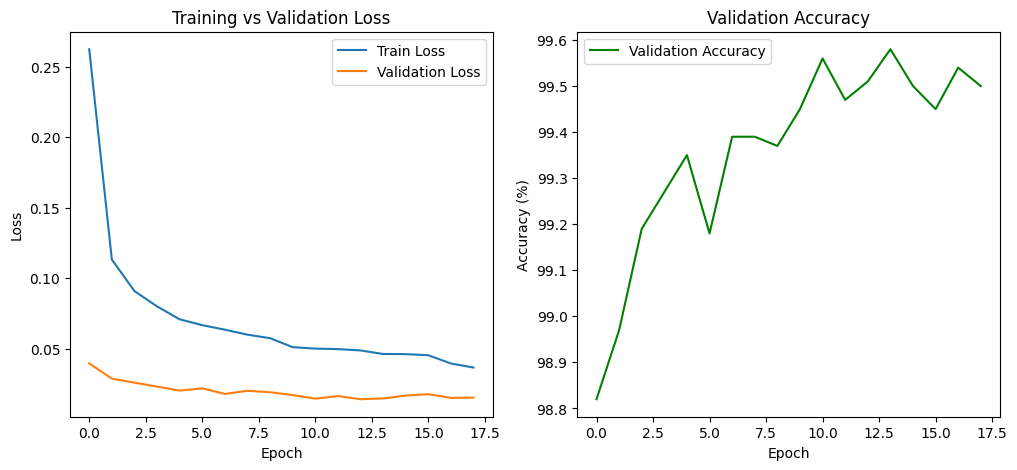

In [4]:
import matplotlib.pyplot as plt

# 绘制 Loss 曲线
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# 绘制准确率曲线
plt.subplot(1,2,2)
plt.plot(accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()
